In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import random
import glob
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import cv2
import skimage

In [3]:
IMAGE_SIZE = 1000
SPOTLIGHT_PROB = 0.3
FONTS_DIR = "../NN_recognition_train/dataset/fonts/*"

In [4]:
def rand_error(r = 0.02):
    return int(random.uniform(-r, r)*IMAGE_SIZE)

def get_random_bright_color():
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    R,G,B = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return R,G,B

def get_dirty_white():
    h,s,l = random.random(), random.random()/3, 0.95 + random.random()/20.0
    R,G,B = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return R,G,B

In [5]:
from scipy.stats import norm

def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    def generate_spot_light_mask(mask_size,
                                position=None,
                                max_brightness=255,
                                min_brightness=0,
                                mode="gaussian",
                                linear_decay_rate=None,
                                speedup=False):
        """
        Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
        Args:
            mask_size: tuple of integers (w, h) defining generated mask size
            position: list of tuple of integers (x, y) defining the center of spotlight light position,
                    which is the reference point during rotating
            max_brightness: integer that max brightness in the mask
            min_brightness: integer that min brightness in the mask
            mode: the way that brightness decay from max to min: linear or gaussian
            linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
            speedup: use `shrinkage then expansion` strategy to speed up vale calculation
        Return:
            light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                        minimum value could be smaller than given min_brightness.
        """
        if position is None:
            position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
        if linear_decay_rate is None:
            if mode == "linear_static":
                linear_decay_rate = random.uniform(0.20, 2)
        assert mode in ["linear", "gaussian"], \
            "mode must be linear_dynamic, linear_static or gaussian"
        mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
        if mode == "gaussian":
            mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
            dev = mu / 3.5
            mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
        mask = np.asarray(mask, dtype=np.uint8)
        # add median blur
        mask = cv2.medianBlur(mask, 5)
        mask = 255 - mask
        # cv2.imshow("mask", mask)
        # cv2.waitKey(0)
        return mask

    def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
        """
        _decay_value_radically_norm function in matrix format
        """
        center_prob = norm.pdf(0, 0, dev)
        x_value_rate = np.zeros((mask_size[1], mask_size[0]))
        for center in centers:
            coord_x = np.arange(mask_size[0])
            coord_y = np.arange(mask_size[1])
            xv, yv = np.meshgrid(coord_x, coord_y)
            dist_x = xv - center[0]
            dist_y = yv - center[1]
            dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
            x_value_rate += norm.pdf(dist, 0, dev) / center_prob
        mask = x_value_rate * (max_value - min_value) + min_value
        mask[mask > 255] = 255
        return mask

    def _decay_value_radically_norm(x, centers, max_value, min_value, dev):
        """
        Calculate point value decayed from center following Gaussian decay. If multiple centers are given, value
        from each center sums up while limiting the accumulated value into [0, 255]
        NOTE: assuming light at each center is identical: same brightness and same decay rate
        """
        center_prob = norm.pdf(0, 0, dev)
        x_value_rate = 0
        for center in centers:
            distance = np.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2)
            x_value_rate += norm.pdf(distance, 0, dev) / center_prob
        x_value = x_value_rate * (max_value - min_value) + min_value
        x_value = 255 if x_value > 255 else x_value
        return x_value
    if transparency is None:
        transparency = random.uniform(0.8, 0.99)
    frame = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)  
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

In [6]:
def get_random_target():
    R,G,B = get_random_bright_color()
    R_w, G_w, B_w = get_dirty_white()

    img = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color = (R_w, G_w, B_w))
    coloured_box = Image.new('RGB', (IMAGE_SIZE//2 + rand_error(), IMAGE_SIZE//2 + rand_error()), color = (R, G, B))

    img.paste(coloured_box,(IMAGE_SIZE//4 + rand_error(0.03), IMAGE_SIZE//4 + rand_error(0.03)))

    letter = random.choice("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    font = random.choice(glob.glob(FONTS_DIR))
    fnt = ImageFont.truetype(font, int(IMAGE_SIZE*0.75/2) + rand_error())

    d = ImageDraw.Draw(img)
    w,h = fnt.getsize(letter)
    d.text(((IMAGE_SIZE-w)//2 + rand_error(),(IMAGE_SIZE-h)//2 + rand_error()), letter, font=fnt, fill=(R_w, G_w, B_w))

    if random.random() < SPOTLIGHT_PROB:
        img = add_spot_light(img)
        img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) 
    else:
        img = np.asarray(img, dtype=np.uint8)
        img = Image.fromarray(img)
    return img, letter, (R,G,B)

In [7]:

def paste_square(target_coords, grass_img, square_img, rand_blur = True):
    def find_coeffs(source_coords, target_coords):
        matrix = []
        for s, t in zip(source_coords, target_coords):
            matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
            matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
        A = np.matrix(matrix, dtype=np.float)
        B = np.array(source_coords).reshape(8)
        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    coeffs = find_coeffs(
        [(0, 0), (0, IMAGE_SIZE), (IMAGE_SIZE, 0), (IMAGE_SIZE, IMAGE_SIZE)],
        target_coords)

    warped_square_img = square_img.transform(grass_img.size, Image.PERSPECTIVE, coeffs,
                  Image.BICUBIC, fillcolor = "#FFFFFF")
    if rand_blur:
        radius = random.uniform(0,1)
        warped_square_img = warped_square_img.filter(ImageFilter.GaussianBlur(radius=radius))


    mask = Image.new('L', square_img.size, color = 255).transform(grass_img.size, Image.PERSPECTIVE, coeffs,
                  Image.BICUBIC)
    if rand_blur:
        mask = mask.filter(ImageFilter.GaussianBlur(radius=radius))

    grass_img.paste(warped_square_img, (0,0), mask)
    return grass_img


In [8]:

def stitch_random_square(file_grass_img):
    grass_img = Image.open(file_grass_img)
    square_img, letter, color = get_random_target()
    
    square_initial_size = random.randint(30,150)
    A_X, A_Y = square_initial_size//2,square_initial_size//2
    B_X, B_Y = A_X, A_Y + square_initial_size
    C_X, C_Y = random.randint(int(A_X + 0.9 * square_initial_size), int(A_X + 1.1 * square_initial_size)), random.randint(int(A_Y - 0.1 * square_initial_size), int(A_Y + 0.1 * square_initial_size))
    D_X, D_Y = random.randint(int(B_X + 0.9 * square_initial_size), int(B_X + 1.1 * square_initial_size)), random.randint(int(B_Y - 0.1 * square_initial_size), int(B_Y + 0.1 * square_initial_size))

    theta = random.uniform(0,6.28)
    r = np.array(( (np.cos(theta), -np.sin(theta)),
                   (np.sin(theta),  np.cos(theta)) ))

    A_X, A_Y = np.dot(np.array((A_X, A_Y)), r)
    B_X, B_Y = np.dot(np.array((B_X, B_Y)), r)
    C_X, C_Y = np.dot(np.array((C_X, C_Y)), r)
    D_X, D_Y = np.dot(np.array((D_X, D_Y)), r)

    t_X, t_Y = random.randint(square_initial_size,900), random.randint(square_initial_size,900)

    A_X, B_X, C_X, D_X = A_X + t_X, B_X + t_X, C_X + t_X, D_X + t_X
    A_Y, B_Y, C_Y, D_Y = A_Y + t_Y, B_Y + t_Y, C_Y + t_Y, D_Y + t_Y
    grass_img = paste_square([(int(A_X), int(A_Y)), (int(B_X), int(B_Y)), (int(C_X), int(C_Y)), (int(D_X), int(D_Y))], grass_img, square_img)
    
    X = np.mean([A_X, B_X, C_X, D_X])
    Y = np.mean([A_Y, B_Y, C_Y, D_Y])
    coords = {"X":X, "Y":Y, "A_X":A_X, "B_X":B_X, "C_X":C_X, "D_X":D_X, "A_Y":A_Y, "B_Y":B_Y, "C_Y":C_Y, "D_Y":D_Y}

    return np.array(grass_img), coords, letter, color


In [9]:
grass_directory = "../data/grass_pretrain"

In [10]:
list_of_grass_images = glob.glob(grass_directory + "/*jpeg")

In [11]:
file_grass_img = random.choice(list_of_grass_images)

In [12]:
img,coords,letter,color = stitch_random_square(random.choice(list_of_grass_images))
print(coords,letter,color )

{'X': 643.0915094019722, 'Y': 501.38350027311924, 'A_X': 679.166450839607, 'B_X': 709.5088783323615, 'C_X': 572.1224941350341, 'D_X': 611.5682143008864, 'A_Y': 569.1023942412816, 'B_Y': 464.41076566551175, 'C_Y': 543.2839641373904, 'D_Y': 428.73687704829297} L (4, 189, 213)


In [13]:
np.array(img)

array([[[ 82, 109,  64],
        [ 84, 111,  66],
        [ 86, 113,  68],
        ...,
        [108, 152,  93],
        [105, 149,  90],
        [106, 150,  91]],

       [[ 83, 110,  65],
        [ 85, 112,  67],
        [ 87, 114,  69],
        ...,
        [110, 154,  95],
        [106, 150,  91],
        [106, 150,  91]],

       [[ 86, 113,  68],
        [ 87, 114,  69],
        [ 89, 116,  71],
        ...,
        [112, 156,  97],
        [108, 152,  93],
        [108, 152,  93]],

       ...,

       [[ 96, 125,  71],
        [ 95, 124,  70],
        [ 94, 123,  69],
        ...,
        [118, 159,  93],
        [114, 155,  89],
        [113, 153,  90]],

       [[ 96, 125,  71],
        [ 96, 125,  71],
        [ 95, 124,  70],
        ...,
        [121, 161,  98],
        [117, 157,  94],
        [115, 155,  92]],

       [[ 97, 126,  72],
        [ 98, 127,  73],
        [ 96, 125,  71],
        ...,
        [119, 159,  96],
        [116, 156,  93],
        [113, 153,  90]]

In [515]:
for i in range(25):
    a,b,c,d,e = stitch_random_square(random.choice(list_of_grass_images))
    a.save(f"show_you_{i}" + ".jpeg")


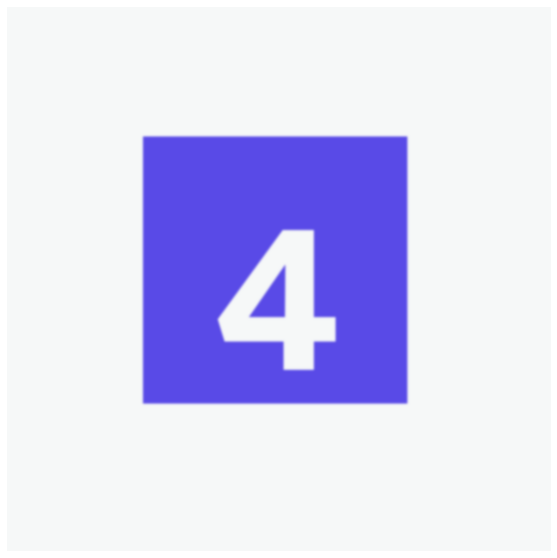

In [25]:
square_img, letter, color = get_random_target()
plt.figure(figsize=(10,10))
plt.axis(False)
square_img = square_img.filter(ImageFilter.GaussianBlur(radius=2))
plt.imshow(square_img)


In [14]:
A = (random.randint(-100, 1100), random.randint(-100, 1100))
B = (A[0] + random.randint(-300, 300), A[1] + random.randint(-300, 300)) 

In [15]:
grad = (B[1] - A[1])/(B[0] - A[0])
c = midpoint[1] - grad * midpoint[0]
midpoint = ((B[0] + A[0])/2, (B[1] + A[1])/2)

NameError: name 'midpoint' is not defined

In [16]:
new_X = random.randint(int(midpoint[0]), B[0])
new_Y = grad*new_X + c

NameError: name 'midpoint' is not defined

In [188]:
p_grad = -1/grad
p_c = midpoint[1] - p_grad * midpoint[0]
r = random.randint(0,300)
new_new_X = new_X + math.cos(math.atan(p_grad))*r
new_new_Y = new_Y + math.sin(math.atan(p_grad))*r

In [189]:
new_X, new_Y

(353, 862.5694915254237)

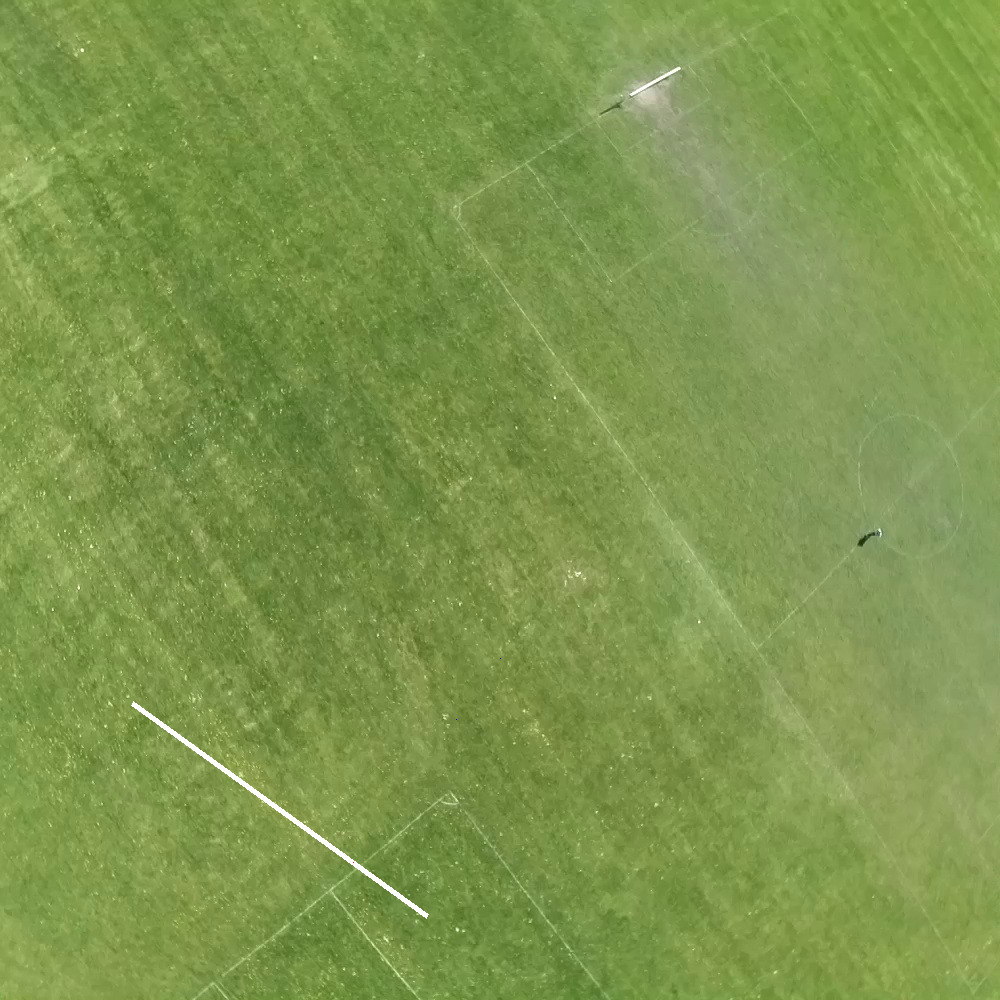

In [190]:
d = ImageDraw.Draw(grass_img)
d.line((A,B), width=5)
d.point((new_X,new_Y), fill = "red")
d.point((new_new_X,new_new_Y), fill = "blue")
grass_img